In [38]:
import numpy as np
from IPython.display import HTML
import matplotlib.pyplot as plt
import torch
from model import PhiNN
from dataset import LandscapeSimulationDataset
from helpers import jump_function

## Examine training and validation datasets

In [39]:
datdir_train = "data/model_training_data_2"
datdir_valid = "data/model_validation_data_2"
nsims_train = 100
nsims_valid = 30

In [40]:
train_dataset = LandscapeSimulationDataset(
    datdir_train, nsims_train, 2, 
    transform='tensor', 
    target_transform='tensor'
)

validation_dataset = LandscapeSimulationDataset(
    datdir_valid, nsims_valid, 2, 
    transform='tensor', 
    target_transform='tensor'
)

We can preview an individual training datum, which consists of a distribution of cells $X_0\in\mathbb{R}^{n\times d}$ at time $t_0$, and a subsequent distribution of cells $X_1\in\mathbb{R}^{n\times d}$ at time $t_1$, along with parameters $\vec{p}\in\mathbb{R}^{n_{p}}$, where $n$ is the number of cells, $d$ the dimension of the cells, and $n_p$ the number of parameters that parameterize the signal function $f_{sig}(t,\cdot)$.


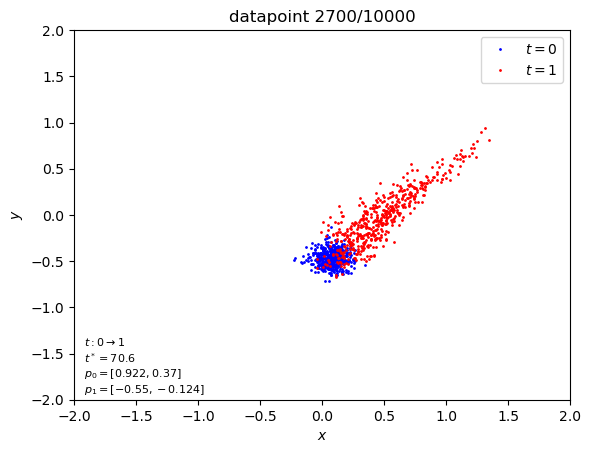

In [41]:
idx = 2700
r = 2
train_dataset.preview(idx, xlims=[-r,r], ylims=[-r,r]);

We can view an animation of a full simulation, which consists of many consecutive time point pairs

In [42]:
simidx = 9
r = 2
ani = train_dataset.animate(
    simidx, xlims=[-r, r], ylims=[-r,r], 
    show=False
)

In [43]:
HTML(ani)

## Examine models

In [44]:
# model_dir = "models/model5122611"
# model_name = "model5122611_20231027_164241"
model_dir = "models/model5359229/"
model_name = "model5359229_20231028_132034"

loss_hist_train = np.load(f"{model_dir}/training_loss_history.npy")
loss_hist_valid = np.load(f"{model_dir}/validation_loss_history.npy")

ncells = int(np.genfromtxt(f"{model_dir}/ncells.txt"))
sigma = float(np.genfromtxt(f"{model_dir}/sigma.txt"))

best_idx = np.argmin(loss_hist_valid)
model_fpath = f"{model_dir}/{model_name}_{best_idx}"

In [45]:
loss_hist_train = loss_hist_train[:-8]
loss_hist_valid = loss_hist_valid[:-8]

Plot the training and validation loss histories.

Text(0.5, 1.0, 'Validation Loss')

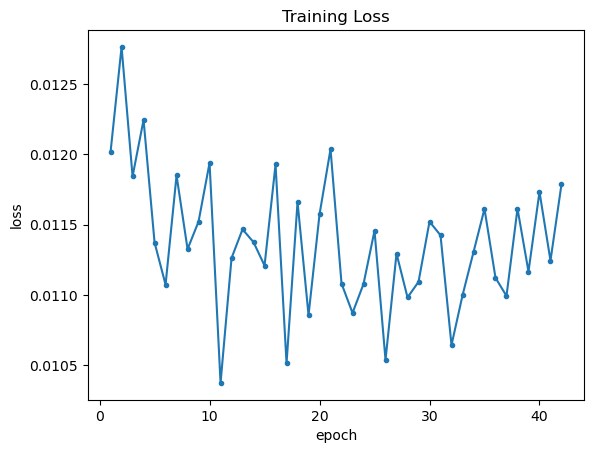

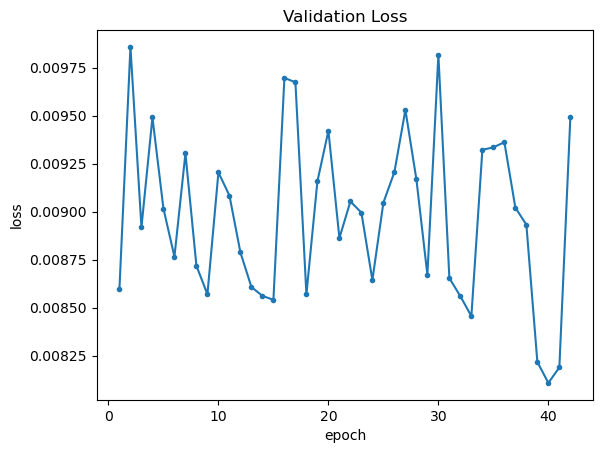

In [46]:
fig, ax = plt.subplots(1, 1)
ax.plot(1+np.arange(len(loss_hist_train)), loss_hist_train, '.-')
ax.set_xlabel(f"epoch")
ax.set_ylabel(f"loss")
ax.set_title(f"Training Loss")

fig, ax = plt.subplots(1, 1)
ax.plot(1+np.arange(len(loss_hist_valid)), loss_hist_valid, '.-')
ax.set_xlabel(f"epoch")
ax.set_ylabel(f"loss")
ax.set_title(f"Validation Loss")

In [47]:
f_signal = lambda t, p: jump_function(t, p[...,0], p[...,1:3], p[...,3:])
model = PhiNN(
    ndim=2, nsig=2, f_signal=f_signal,
    ncells=ncells, 
    sigma=sigma,
    sample_cells=True,
)

model.load_state_dict(torch.load(model_fpath, map_location=torch.device('cpu')))
model.eval();

## Plot of the force field

torch.Size([1, 400, 1])


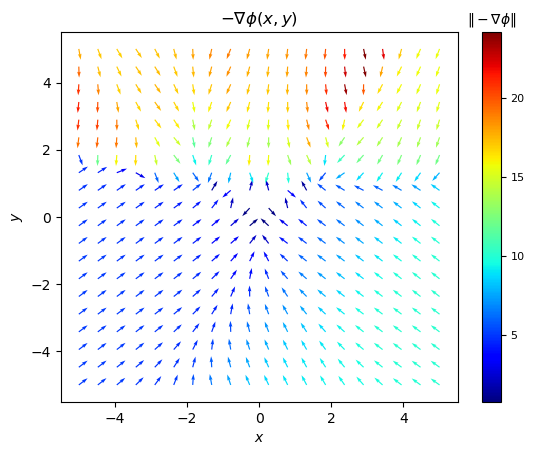

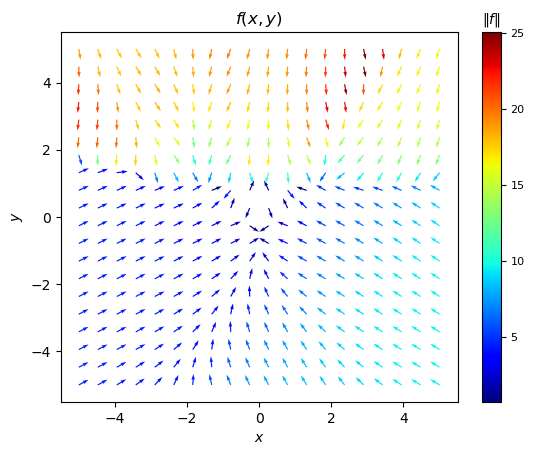

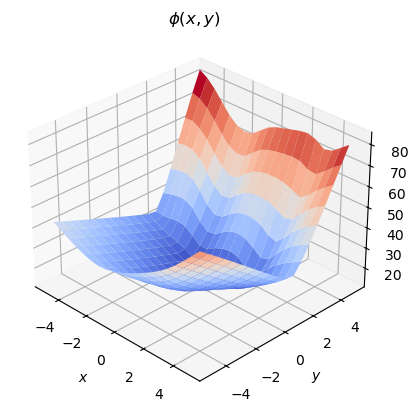

In [62]:
# State space
r = 5
x = np.linspace(-r, r, 20)
y = np.linspace(-r, r, 20)
xs, ys = np.meshgrid(x, y)
z = np.array([xs.flatten(), ys.flatten()]).T
z = torch.tensor([z], dtype=torch.float32, requires_grad=True)

# Signal function
tcrit = 0
p0 = [0, 0]
p1 = [0, 1]

# Evaluation time
t = 10  

signal_params = np.array([tcrit, *p0, *p1])
signal_params = torch.tensor([signal_params], dtype=torch.float32)

f = model.f(torch.tensor([t], dtype=torch.float32), z, signal_params)
grad_phi = -model.grad_phi(torch.tensor([t], dtype=torch.float32), z).detach()
phi = model.phi(z).detach()

f_arr = f.detach().numpy()
fu, fv = f_arr.T
fnorms = np.sqrt(fu**2 + fv**2)

grad_phi_arr = grad_phi.detach().numpy()
gphiu, gphiv = grad_phi_arr.T
gphinorms = np.sqrt(gphiu**2 + gphiv**2)

# Plot force field generated by the landscape (untilted)
fig, ax = plt.subplots(1, 1)
ax.set_xlabel(f"$x$")
ax.set_ylabel(f"$y$")
ax.set_title(f"$-\\nabla\phi(x,y)$")
sc = ax.quiver(xs, ys, gphiu/gphinorms, gphiv/gphinorms, gphinorms, cmap='jet')
cbar = plt.colorbar(sc)
cbar.ax.set_title("$\|-\\nabla\phi\|$", size=10)
cbar.ax.tick_params(labelsize=8)

# Plot force field, tilted by signals
fig, ax = plt.subplots(1, 1)
ax.set_xlabel(f"$x$")
ax.set_ylabel(f"$y$")
ax.set_title(f"$f(x,y)$")
sc = ax.quiver(xs, ys, fu/fnorms, fv/fnorms, fnorms, cmap='jet')
cbar = plt.colorbar(sc)
cbar.ax.set_title("$\|f\|$", size=10)
cbar.ax.tick_params(labelsize=8)

# Plot Landscape Phi
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.set_xlabel(f"$x$")
ax.set_ylabel(f"$y$")
ax.set_title(f"$\phi(x,y)$")
ax.plot_surface(xs, ys, phi.reshape(xs.shape), cmap='coolwarm')
ax.view_init(30, -45)

In [49]:
t0 = 0
t1 = 10
y0 = np.random.rand(ncells, 2)
sigparams = [5, 0, 0, 1, 1]

inputs = (
    torch.tensor([t0], dtype=torch.float32),
    torch.tensor([t1], dtype=torch.float32),
    torch.tensor([y0], dtype=torch.float32, requires_grad=True),
    torch.tensor([sigparams], dtype=torch.float32),
)
z, z_hist = model.simulate_forward(*inputs, dt=1e-1, history=True)

In [50]:
# State space
r = 4
x = np.linspace(-r, r, 20)
y = np.linspace(-r, r, 20)
xs, ys = np.meshgrid(x, y)
z = np.array([xs.flatten(), ys.flatten()]).T
z = torch.tensor([z], dtype=torch.float32, requires_grad=True)

# Signal function
tcrit = sigparams[0]
p0 = sigparams[1:3]
p1 = sigparams[3:5]
sigparams_tensor = torch.tensor([sigparams], dtype=torch.float32)

tvals = np.linspace(0, 10, len(z_hist))
for i, t in enumerate(tvals):
    if i % 10 != 0:
        continue
    f = model.f(torch.tensor([t]), z, sigparams_tensor)
    phi = model.phi(z).detach()
    f_arr = f.detach().numpy()
    u, v = f_arr.T
    norms = np.sqrt(u**2 + v**2)

    fig, ax = plt.subplots(1, 1, figsize=(6.4, 4.8))
    ax.set_xlabel(f"$x$")
    ax.set_ylabel(f"$y$")
    ax.set_title(f"$f(x,y), t={t:.4f}$")
    sc = ax.quiver(xs, ys, u/norms, v/norms, norms, cmap='jet')
    cbar = plt.colorbar(sc)
    cbar.ax.set_title("$\|f\|$", size=10)
    cbar.ax.tick_params(labelsize=8)
    outdir = "out/snaps"

    ax.scatter(z_hist[i][0,:,0], z_hist[i][0,:,1], s=1)

    plt.savefig(f"{outdir}/frame{i}.png")
    plt.close()

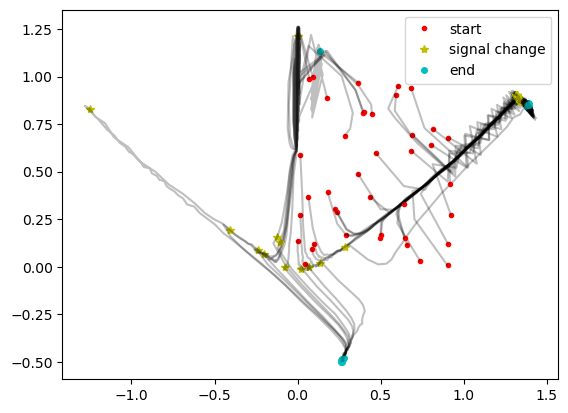

In [51]:
batch_idx = 0

fig, ax = plt.subplots(1, 1)
changeidx = np.argmin(np.abs(tvals-tcrit))
for idx in range(40):
    ztraj = np.array([zi[batch_idx, idx] for zi in z_hist]).T
    ax.plot(ztraj[0,0], ztraj[1,0], 'r.')
    ax.plot(ztraj[0,changeidx], ztraj[1,changeidx], 'y*')
    ax.plot(ztraj[0,-1], ztraj[1,-1], 'co', markersize=4)
    ax.plot(ztraj[0], ztraj[1], 'k', alpha=0.25)

ax.legend(['start', 'signal change', 'end']);

In [52]:
# from animator import SimulationAnimator

# simdir = "data/model_training_data/sim0"
# ani = SimulationAnimator(
#     ts=np.load(f"{simdir}/ts.npy"),
#     xys=np.load(f"{simdir}/xs.npy")
# )

# ani.animate('delme');

## Comparison between data and prediction

Compare the learned landscape $\phi$ with the true landscape that generated the data,
$$\phi^*(x,y)=x^4+y^4+y^3-4x^2y+y^2-p_1x+p_2y$$
where we fix $p_1=p_2=0$ to define the untilted, *underlying* landscape.


In [ ]:
def func_phi_star(x, y, p1=0, p2=0):
    return x**4 + y**4 + y**3 - 4*x*x*y + y*y - p1*x + p2*y

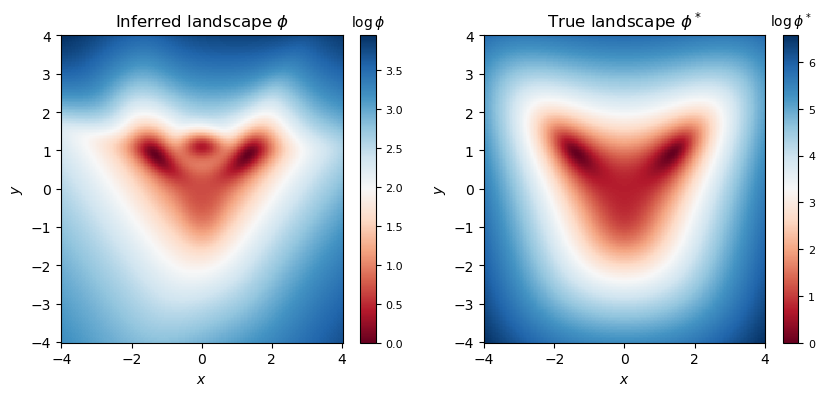

In [98]:
r = 4  # box radius
res = 200  # resolution

signal = [0, 1]  # signal

tt = torch.tensor([t])
signal_params = np.array([10, *signal, 0, 0])
signal_params = torch.tensor([signal_params], dtype=torch.float32)

x = np.linspace(-r, r, res)
y = np.linspace(-r, r, res)
xs, ys = np.meshgrid(x, y)
z = np.array([xs.flatten(), ys.flatten()]).T
z = torch.tensor([z], dtype=torch.float32, requires_grad=True)

phi = model.phi(z).detach()
phi_star = func_phi_star(xs, ys)

phi = np.log(1 + phi - phi.min())
phi_star = np.log(1 + phi_star - phi_star.min())

fig, axes = plt.subplots(1, 2, figsize=(10,4))

# Plot inferred landscape
ax = axes[0]
sc = ax.pcolormesh(
    xs, ys, phi.reshape(xs.shape), 
    cmap='RdBu', 
    vmin=phi.min(), vmax=phi.max()
)

ax.set_xlabel(f"$x$")
ax.set_ylabel(f"$y$")
ax.set_title(f"Inferred landscape $\phi$")

cbar = plt.colorbar(sc)
cbar.ax.set_title("$\log\phi$", size=10)
cbar.ax.tick_params(labelsize=8)

# Plot true landscape
ax = axes[1]
sc = ax.pcolormesh(
    xs, ys, phi_star.reshape(xs.shape), 
    cmap='RdBu', 
    vmin=phi_star.min(), vmax=phi_star.max()
)

ax.set_xlabel(f"$x$")
ax.set_ylabel(f"$y$")
ax.set_title(f"True landscape $\phi^*$")

cbar = plt.colorbar(sc)
cbar.ax.set_title("$\log\phi^*$", size=10)
cbar.ax.tick_params(labelsize=8)


[-0.9746272   0.00976015]
(40000, 1) (2,) (200, 200) (200, 200) torch.Size([1, 40000, 2])


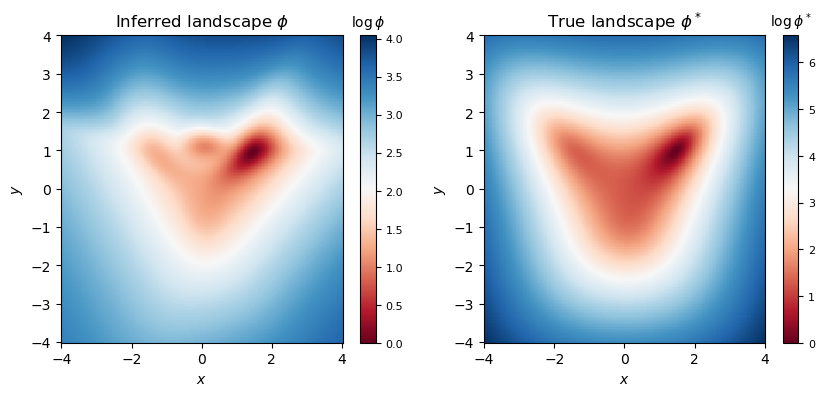

In [120]:
r = 4  # box radius
res = 200  # resolution
signal = [1, 0]  # signal

tt = torch.tensor([0])
signal_params = np.array([10, *signal, 0, 0])
signal_params = torch.tensor([signal_params], dtype=torch.float32)

x = np.linspace(-r, r, res)
y = np.linspace(-r, r, res)
xs, ys = np.meshgrid(x, y)
z = np.array([xs.flatten(), ys.flatten()]).T
z = torch.tensor([z], dtype=torch.float32, requires_grad=True)

phi = model.phi(z).detach().numpy()[0]
tilt = model.grad_tilt(tt, signal_params).detach().numpy()[0]
print(tilt)
print(phi.shape, tilt.shape, xs.shape, ys.shape, z.shape)
phi = phi.reshape(xs.shape) + xs*tilt[0] + ys*tilt[1]

phi_star = func_phi_star(xs, ys, signal[0], signal[1])

# Normalize the landscapes to have unit minimum
phi = np.log(1 + phi - phi.min())
phi_star = np.log(1 + phi_star - phi_star.min())

fig, axes = plt.subplots(1, 2, figsize=(10,4))

# Plot inferred landscape (TILTED)
ax = axes[0]
sc = ax.pcolormesh(
    xs, ys, phi.reshape(xs.shape), 
    cmap='RdBu', 
    vmin=phi.min(), vmax=phi.max()
)

ax.set_xlabel(f"$x$")
ax.set_ylabel(f"$y$")
ax.set_title(f"Inferred landscape $\phi$")

cbar = plt.colorbar(sc)
cbar.ax.set_title("$\log\phi$", size=10)
cbar.ax.tick_params(labelsize=8)

# Plot true landscape (TILTED)
ax = axes[1]
sc = ax.pcolormesh(
    xs, ys, phi_star.reshape(xs.shape), 
    cmap='RdBu', 
    vmin=phi_star.min(), vmax=phi_star.max()
)

ax.set_xlabel(f"$x$")
ax.set_ylabel(f"$y$")
ax.set_title(f"True landscape $\phi^*$")

cbar = plt.colorbar(sc)
cbar.ax.set_title("$\log\phi^*$", size=10)
cbar.ax.tick_params(labelsize=8)


In [84]:
tilt_params = list(model.tilt_nn.parameters())
print(tilt_params)

[Parameter containing:
tensor([[-0.9746,  0.0396],
        [ 0.0098,  0.9318]], requires_grad=True)]
